# 8장. 이미지를 분류합니다

## 08-1 합성곱을 알아 봅니다.

In [1]:
#@title
import numpy as np

In [2]:
#@title
## 배열 x, y 정의
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [3]:
#@title
## flip : 배열을 뒤집는다.
w_r = np.flip(w)
print(w_r)

[3 5 1 2]


In [4]:
#@title
## 배열을 한칸씩 이동하면서 넘파이의 점곱을 이용하여 합성곱을 수행함.
for i in range(6):
    print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


## 08-4 케라스로 합성곱 신경망 모델을 만듭니다.

In [5]:
#@title
import tensorflow as tf

In [6]:
#@title
## 패션 데이터 로드
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [9]:
#@title
## 훈련데이터세트를 훈련세트와 검증세트로 나눔
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [10]:
#@title
## 타겟을 원핫인코딩으로 변환함
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [11]:
#@title
## 합성곱 신경망은 입력데이터(이미지)를 일렬로 펼칠 필요가 없음. 그래서 높이와 너비를 그대로 유지한 채 신경망에 주입함.
## 대신 마지막에 컬러채널을 추가해야 함. 단, 여기서는 흑백이미지이므로 명암을 나타내는 1차원만 있음.
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [12]:
#@title
x_train.shape

(48000, 28, 28, 1)

In [13]:
#@title
## 데이터 전처리 : 0~255 ==> 0~1
x_train = x_train / 255
x_val = x_val / 255

In [14]:
#@title
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [15]:
#@title
conv1 = tf.keras.Sequential()
## Conv2D : 첫번째 매개변수는 합성곱 커널의 개수, 두번째 매개변수는 합성곱 커널의 높이와 너비
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv1.add(MaxPooling2D((2, 2)))
## 완전연결층에 연결하기 위해 일렬로 펼침
conv1.add(Flatten())
## 은닉층 뉴런 100개
conv1.add(Dense(100, activation='relu'))
## 출력층 뉴런 10개
conv1.add(Dense(10, activation='softmax'))

In [16]:
#@title
## Conv2d : (28 높이, 28 너비, 10 커널수) /  모델파라미터(가중치, 절편) 100=3(합성곱필터높이)*3(합성곱필터너비)*10(커널수)+10(커널당절편1개)
## max_poolin2d : 2*2 풀링을 적용하여, 이미지의 높이와 너비가 절반으로 감소하고 커널수는 유지되므로, 14(높이)*14(너비)*10(커널수), (max pooling층은 모델파라미터(가중치) 없음)
## flatten 1960개=14*14*10 가 이후 100개의 뉴런에 연결됨. (Flatten층 모델파라미터(가중치) 없음)
## dense (Dense) 첫번째 완전연결층의 가중치 개수 = 196,100 개 = 1,960(Flatten출력개수)*100(은닉층뉴런개수)+100(은닉층절편수)
## dense_1(Dense) 두번째 완전연결층의 가중치 개수 = 1,010개 = 100(은닉층 뉴런개수)*10(출력층뉴런개수)+10(출력층절편수)
## 결론적으로 가중치의 개수를 보면 완전연결층에 비해 합성곱층의 가중치 개수가 아주 적다.
conv1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1960)              0         
                                                                 
 dense (Dense)               (None, 100)               196100    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
__________________________________________________

In [17]:
#@title
## 다중분류용 손실함수인 크로스 엔트로피를 사용
## 아담 옵티마이저 : 손실함수의 값이 최적값에 가까워질수록 학습률을 낮춰 손실함수 값이 안정적으로 수렴될 수 있게 함.
conv1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
#@title
## 최종 20 epoch 수행 후 결과를 보면, "loss: 0.0361 - acc: 0.9878 - val_loss: 0.4157 - val_acc: 0.9143" ==> 과적합(Overfitting)임.
history = conv1.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 9s 5ms/step - loss: 0.4772 - accuracy: 0.8329 - val_loss: 0.3474 - val_accuracy: 0.8808
Epoch 2/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3339 - accuracy: 0.8815 - val_loss: 0.3101 - val_accuracy: 0.8904
Epoch 3/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2858 - accuracy: 0.8966 - val_loss: 0.2849 - val_accuracy: 0.8988
Epoch 4/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2522 - accuracy: 0.9078 - val_loss: 0.2660 - val_accuracy: 0.9049
Epoch 5/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2244 - accuracy: 0.9173 - val_loss: 0.2816 - val_accuracy: 0.9019
Epoch 6/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1998 - accuracy: 0.9268 - val_loss: 0.2650 - val_accuracy: 0.9082
Epoch 7/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1818 - accuracy: 0.9339 - val_loss: 0.2637 - val_accuracy:

In [19]:
#@title
import matplotlib.pyplot as plt

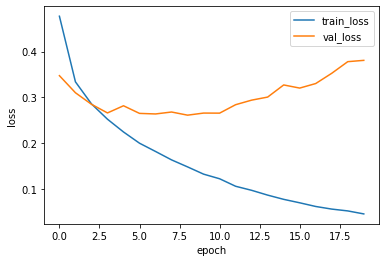

In [20]:
#@title
## 불과 몇번의 에포크만에 검증손실이 크게 증가 ==> 과적합(Overfitting) 조기에 발생
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

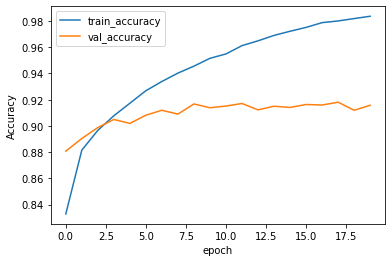

In [21]:
#@title
## 검증데이터에 대한 정확도는 정체 ==> 과적합이 조기에 발생하였음
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [22]:
#@title
loss, accuracy = conv1.evaluate(x_val, y_val_encoded, verbose=0)

In [23]:
#@title
## 검증 정확도 향상 : (합성곱미적용시)86% ==> (합성곱적용시)91%
print(accuracy)

0.9157500267028809


In [24]:
#@title
## 과적합을 해결하기 위해 드롭아웃 적용
from tensorflow.keras.layers import Dropout

In [25]:
#@title
conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

In [26]:
#@title
conv2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1960)              0         
                                                                 
 dropout (Dropout)           (None, 1960)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               196100    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                      

In [27]:
#@title
conv2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
#@title
## 최종 20 epoch 수행 후 결과를 보면, "loss: 0.1755 - acc: 0.9350 - val_loss: 0.2278 - val_acc: 0.9225" ==> DropOut 적용 후 과적합(Overfitting) 완화됨.
history = conv2.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4820 - accuracy: 0.8295 - val_loss: 0.3339 - val_accuracy: 0.8825
Epoch 2/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3603 - accuracy: 0.8698 - val_loss: 0.2899 - val_accuracy: 0.8941
Epoch 3/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.3224 - accuracy: 0.8815 - val_loss: 0.2833 - val_accuracy: 0.8961
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2988 - accuracy: 0.8896 - val_loss: 0.2631 - val_accuracy: 0.9057
Epoch 5/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2803 - accuracy: 0.8957 - val_loss: 0.2574 - val_accuracy: 0.9080
Epoch 6/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2644 - accuracy: 0.9013 - val_loss: 0.2522 - val_accuracy: 0.9068
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2514 - accuracy: 0.9057 - val_loss: 0.2456 - val_accuracy:

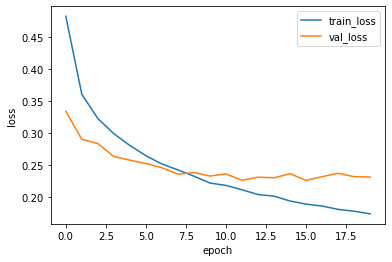

In [29]:
#@title
## 검증손실이 증가되는 에포크가 확실히 더 늦춰짐, 훈련손실과의 차이도 좁혀짐
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

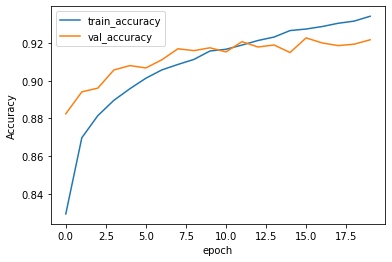

In [30]:
#@title
## DropOut 적용 후 과적합(Overfitting) 완화됨.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [31]:
#@title
loss, accuracy = conv2.evaluate(x_val, y_val_encoded, verbose=0)

In [32]:
#@title
## 정확도 미세 증가
print(accuracy)

0.92166668176651
